C:\Users\ranadeva\AppData\Local\Temp\ipykernel_29772\3664583041.py:57: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_specialty = stroke_total_points.groupby('ID').apply(assign_specialty).reset_index()


Best parameters found:  {'model__max_depth': 7}
Best cross-validation score:  0.6081981528717073
Accuracy: 0.6180886769122064
   max_depth  train accuracy  validation accuracy
0          1        0.575804             0.567924
1          2        0.584614             0.586913
2          3        0.605724             0.602104
3          4        0.611840             0.605813
4          5        0.614070             0.604753
5          6        0.616896             0.606167
6          7        0.618773             0.608198
7          8        0.620363             0.603870
8          9        0.621335             0.602722
9         10        0.621622             0.603517


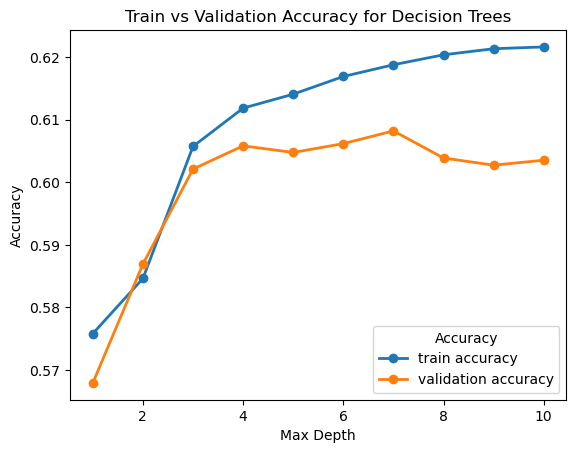

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import graphviz

# Load the cleaned data
df = pd.read_parquet('CLEANED_SWIM_DATA.parquet')

# Step 1: Drop high school records (Division == 'HS')
df = df[df['Division'] != 'HS']

# Step 2: Drop specific events from the analysis
excluded_events = [
    "100 Individual Medley SCY Female", "100 Individual Medley SCY Male",
    "50 Backstroke SCY Female", "50 Backstroke SCY Male",
    "50 Butterfly SCY Female", "50 Butterfly SCY Male",
    "50 Breaststroke SCY Female", "50 Breaststroke SCY Male"
]
df = df[~df['Event'].isin(excluded_events)]

# Step 3: Categorize stroke types (unchanged)
def categorize_stroke(event):
    if 'Freestyle' in event:
        return 'Freestyle'
    elif 'Backstroke' in event:
        return 'Backstroke'
    elif 'Breaststroke' in event:
        return 'Breaststroke'
    elif 'Butterfly' in event:
        return 'Butterfly'
    elif 'Medley' in event:
        return 'Medley'
    else:
        return 'Other'

df['Stroke'] = df['Event'].astype('string').apply(categorize_stroke)

# Step 4: Drop the original 'Event' column
df = df.drop(columns=['Event'])

# Step 5: Group by ID and calculate total points per stroke (using the total sum of points)
def total_points(points):
    return np.sum(points)  # Total points per event (instead of average)

# Calculate total points per swimmer and stroke
stroke_total_points = df.groupby(['ID', 'Stroke'])['Points'].apply(total_points).reset_index()

# Step 6: For each swimmer, find the stroke with the highest total points
def assign_specialty(swimmer_strokes):
    max_stroke = swimmer_strokes.loc[swimmer_strokes['Points'].idxmax()]['Stroke']
    return max_stroke

df_specialty = stroke_total_points.groupby('ID').apply(assign_specialty).reset_index()
df_specialty.rename(columns={0: 'Specialty'}, inplace=True)

# Step 7: Merge the specialty info back into the main dataset
df = df.merge(df_specialty, on='ID')

# Step 8: Binning improvement and power
# Compute improvement from first to last season
first_season = df.groupby('ID')['Points'].first()  # Use Points to compute improvement
last_season = df.groupby('ID')['Points'].last()
df['Improvement'] = df['ID'].map(last_season - first_season)

# Bin the 'Improvement' column into 2 quantiles (instead of 3)
df['ImprovementBin'] = pd.qcut(df['Improvement'], q=2, labels=False)

# Label the bins (Lower, Higher)
bin_means = df.groupby('ImprovementBin')['Improvement'].mean().sort_values()
bin_labels = {bin_means.index[0]: "Lower", bin_means.index[1]: "Higher"}
df['ImprovementBinLabel'] = df['ImprovementBin'].map(bin_labels)

# Step 9: Create 'power_tot_rating' based on 'Power_Tot'
# Use qcut to create a 5-star rating for 'Power_Tot', where lower is better
df['power_tot_rating'] = pd.qcut(df['Power_Tot'], q=5, labels=[5, 4, 3, 2, 1])

# Step 10: Remove unnecessary columns and prepare df_summary
df = df[['ID', 'power_tot_rating', 'ImprovementBin', 'Division', 'Gender', 'School', 'Specialty']]

# Create a new dataframe with 1 row per swimmer
df_summary = df.groupby('ID').agg({
    'power_tot_rating': 'first',
    'ImprovementBin': 'first',
    'Division': 'first',
    'Gender': 'first',
    'School': 'first',
    'Specialty': 'first'
}).reset_index()

# Step 11: Apply OneHotEncoder to categorical columns (excluding 'power_tot_rating')
categorical_columns = ['Division', 'Gender', 'Specialty']
encoder = OneHotEncoder(drop='first', sparse_output=False)

# Apply encoding to categorical features
encoded_categorical_features = encoder.fit_transform(df_summary[categorical_columns])

# Create a new DataFrame with the encoded features
encoded_df = pd.DataFrame(encoded_categorical_features, columns=encoder.get_feature_names_out(categorical_columns))

# Include the 'power_tot_rating' as a numerical feature
encoded_df['power_tot_rating'] = df_summary['power_tot_rating']

# Step 12: Set up DecisionTreeClassifier with GridSearchCV and cross-validation
X = encoded_df
y = df_summary['ImprovementBin']

# Create a pipeline with DecisionTreeClassifier for modeling
pipeline = Pipeline(steps=[
    ('model', DecisionTreeClassifier(random_state=0))
])

# Define parameters for GridSearchCV (testing depths from 1 to 10)
parameters = {'model__max_depth': range(1, 11)}

# Apply GridSearchCV for cross-validation with hyperparameter tuning
dtree_cv = GridSearchCV(pipeline, param_grid=parameters, return_train_score=True, n_jobs=-1)

# Fit the model to the data
dtree_cv.fit(X, y)

# Display the best parameters and the score from cross-validation
print("Best parameters found: ", dtree_cv.best_params_)
print("Best cross-validation score: ", dtree_cv.best_score_)

# Step 13: Post-analysis
# Get the best parameters and accuracy
best_params = dtree_cv.best_params_
accuracy = dtree_cv.score(X, y)
print('Accuracy:', accuracy)

# Extract the parameter values used in the grid search from cv_results_
depth_values = dtree_cv.cv_results_['param_model__max_depth']

# Create a DataFrame to store cross-validation results
results = pd.DataFrame({
    'max_depth': depth_values,
    'train accuracy': dtree_cv.cv_results_['mean_train_score'],
    'validation accuracy': dtree_cv.cv_results_['mean_test_score']
})

# Print the results table
print(results)

# Step 14: Plot the train vs validation accuracy
results.plot(x='max_depth', y=['train accuracy', 'validation accuracy'], marker='o', linestyle='-', linewidth=2)
plt.title('Train vs Validation Accuracy for Decision Trees')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.legend(title='Accuracy')
plt.show()

In [2]:
df_summary.ImprovementBin.value_counts(normalize=True)

ImprovementBin
0    0.52685
1    0.47315
Name: proportion, dtype: float64

Training Accuracy: 0.6128
Validation Accuracy: 0.6128


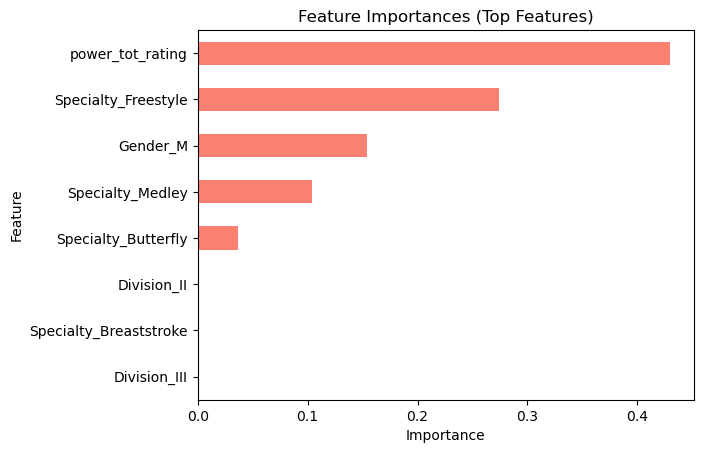

'decision_tree_depth_4.pdf'

In [3]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import graphviz

# Assuming df_summary is already prepared from previous steps

# Step 1: Apply OneHotEncoder to categorical columns (excluding 'power_tot_rating')
categorical_columns = ['Division', 'Gender', 'Specialty']
encoder = OneHotEncoder(drop='first', sparse_output=False)

# Apply encoding to categorical features
encoded_categorical_features = encoder.fit_transform(df_summary[categorical_columns])

# Create a new DataFrame with the encoded features
encoded_df = pd.DataFrame(encoded_categorical_features, columns=encoder.get_feature_names_out(categorical_columns))

# Step 2: Include the 'power_tot_rating' as a numerical feature (do NOT encode it)
encoded_df['power_tot_rating'] = df_summary['power_tot_rating']

# Step 3: Set up DecisionTreeClassifier with max_depth=4
X = encoded_df
y = df_summary['ImprovementBin']

# Create a DecisionTreeClassifier model with max_depth=4
dtree = DecisionTreeClassifier(max_depth=4, random_state=0)

# Fit the model to the data
dtree.fit(X, y)

# Step 4: Calculate and display training and validation accuracy
train_accuracy = dtree.score(X, y)
# For validation accuracy, use cross-validation or a separate validation set (here using the same data as training)
val_accuracy = dtree.score(X, y)  # Note: this is using the same data as training, but for real use, a validation set is needed

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Step 5: Feature importances for the decision tree
feature_importances = dtree.feature_importances_

# Create a DataFrame to display feature importances
df_importances = pd.DataFrame({
    'Feature': encoded_df.columns,
    'Importance': feature_importances
})

# Sort by importance
df_importances = df_importances.sort_values(by='Importance', ascending=False)

# Step 6: Plot Feature Importances as a Bar Chart
df_importances.sort_values(by='Importance', ascending=True).plot.barh(x='Feature', y='Importance', color='salmon', legend=False)
plt.title('Feature Importances (Top Features)')
plt.xlabel('Importance')
plt.show()

# Step 7: Visualize the Decision Tree using Graphviz
dot_data = export_graphviz(dtree, out_file=None,
                           feature_names=encoded_df.columns,  
                           class_names=['Lower', 'Higher'],  
                           filled=True, rounded=True,  
                           special_characters=True)  
graph = graphviz.Source(dot_data)  
graph.render('decision_tree_depth_4', format='png', cleanup=True)  # Saves the tree image as PNG
graph.view()  # Opens the tree visualization
